In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import pprint
import seaborn as sns

In [3]:
# Create engine connection
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [4]:
Base.classes.keys()

['measurement', 'station']

In [5]:
# Assign the classes to variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
session = Session(engine)

### Precipitation Analysis

In [7]:
# Find the latest date of record
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The last date of record is {latest}.")

# Date 12 months before the last date of record
date_start_query = (latest - dt.timedelta(days=365))
print(f"Therefore, query begins on {date_start_query}.")

The last date of record is 2017-08-23.
Therefore, query begins on 2016-08-23.


In [8]:
# Query date and prcp
date_prcp = pd.read_sql("select date, prcp from measurement \
                        where date >= '2016-08-23';", conn)

# Average prcp across stations
date_prcp_avg = date_prcp.groupby(["date"]).mean()
date_prcp_avg.head()

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


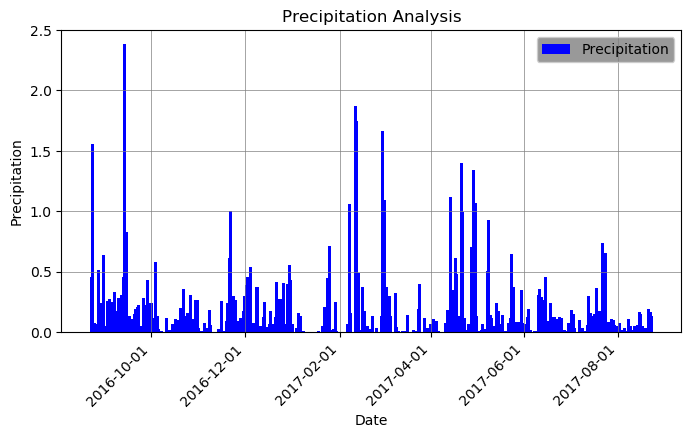

In [18]:
import matplotlib.dates as mdates

#plot data
plt.figure(figsize=(8,4))
plt.bar(pd.to_datetime(date_prcp_avg.index), date_prcp_avg["prcp"], color="b", 
        width=2, label="Precipitation")
plt.gca().set_facecolor("white")

# Format x-tick label
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha="right")

# Other formatting
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Analysis")
plt.legend(frameon=True, facecolor="grey")
plt.grid(linestyle='-', linewidth='0.5', color='grey')

In [17]:
#Summary
date_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [20]:
# Count number of stations
num_stations = session.query(func.count(Station.station)).all()[0][0]
print(f"There are {num_stations} stations total.")

There are 9 stations total.


In [21]:
# Query most active station
active_stations = session.query(Measurement.station, func.count(Measurement.prcp)). \
                    group_by(Measurement.station). \
                    order_by(func.count(Measurement.prcp).desc()).all()
pprint.pprint(active_stations)
print(f"\nStation {active_stations[0][0]} has the highest number of observations.")

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

Station USC00519281 has the highest number of observations.


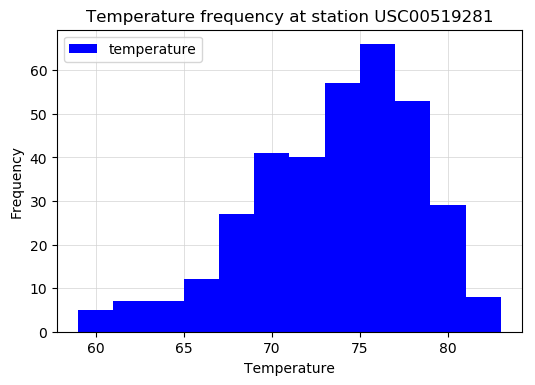

In [23]:
# Query temperatures
tobs_raw = session.query(Measurement.tobs). \
    filter(Measurement.date >= date_start_query). \
    filter(Measurement.station == active_stations[0][0]).all()

# Store temperatures in a list
tobs = [temp[0] for temp in tobs_raw]

# Plot
plt.hist(tobs, bins=12, label="temperature", color="b")
plt.gca().set_facecolor("white")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Temperature frequency at station {active_stations[0][0]}")
plt.legend(frameon=True, facecolor="white")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')
plt.gca().set_axisbelow(True)

### Temperature Analysis

In [24]:
def calc_temps(start_date, end_date):
 
    start_date_dt = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = dt.datetime.strptime(end_date, '%Y-%m-%d')

    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    temps = session.query(*sel). \
                filter(Measurement.date>=start_date_dt). \
                filter(Measurement.date<=end_date_dt).all()[0]
    
    return temps

In [25]:
# Trip Dates
start_date = "2017-06-03"
end_date = "2017-06-13"
[temp_min, temp_avg, temp_max] = calc_temps(start_date, end_date)

print(f"My trip starts on {start_date} and ends on {end_date}. \
For the range of dates, the min temperature is {temp_min}, \
mean temperature is {temp_avg}, and maximum temperature is {temp_max}.")

My trip starts on 2017-06-03 and ends on 2017-06-13. For the range of dates, the min temperature is 72.0, mean temperature is 77.20689655172414, and maximum temperature is 83.0.


Text(0.5,1,"My Trip's average temperature")

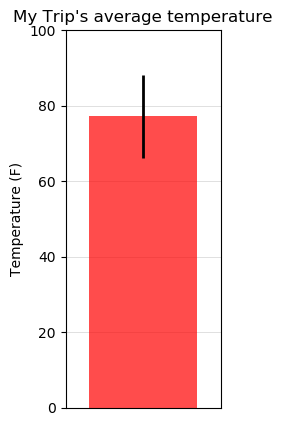

In [26]:
# Plot
plt.figure(figsize=(2,5))
plt.bar(0, temp_avg, color="red", width=1.4, 
        alpha=0.7, yerr=temp_max-temp_min, error_kw={"linewidth":2})
plt.gca().set_facecolor("white")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')
plt.gca().set_axisbelow(True)
plt.gca().set_xticks([])
plt.xlim((-1, 1))
plt.ylim((0, 100))
plt.ylabel("Temperature (F)")
plt.title("My Trip's average temperature")